# Acquisition Functions
Acquisition Functions (acq. functions) are used to find the *best* next possible point to sample when doing Bayesian Optimization. The term *best* in this context depends on what the user wants to achieve. In our case we want to find the most informative point so that our surrogate model (cf. **Bayesian Optimization**). In this notebook I will introduce three acq. functions. The first one is *Expected Improvement (EI)* which is commonly used and easy to implement. After that I will discuss *Mutual Information (MI)* and *Upper Confidence Bound (UCB)*.
## Mutual Information

### Algorithm 1

In [1]:
import utils
import acqfunctions as acq
import gpflow
import numpy as np
import matplotlib
#import math
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib import cm
import time
%matplotlib inline

In [2]:
fontsize_label = 24
fontsize_legend = 20
fontsize_ticks = 20
fontsize_title = 24
linewidth = 2.4
markeredgewidth = 3
markersize = 15 
matplotlib.rcParams['figure.figsize'] = (16, 8)

Now create a data set by drawing from a *RBF* kernel. After that *5* random points are chosen as trainig samples for a GP. The posterior together with the ground truth as well as the observed data points are marked to show how a GP posterior conditioned on randomly selected samples looks like.

In [3]:
# Generate data
np.random.seed(9)
# Set some parameters
f = 0.5
N = 6.
lengthscale = 0.4
num_Functions = 1
num = 15
# Build data sets
X = np.linspace(0., N, num).reshape(num, 1)
k = gpflow.kernels.RBF(1, lengthscales=lengthscale)
Y_true = utils.drawRandomFunction(k, X, num_Functions) 

size = 2
np.random.seed(57)
index = np.random.choice(range(len(X)), size=size, replace=False)
X_sample = X[index]
Y_sample = Y_true[index]

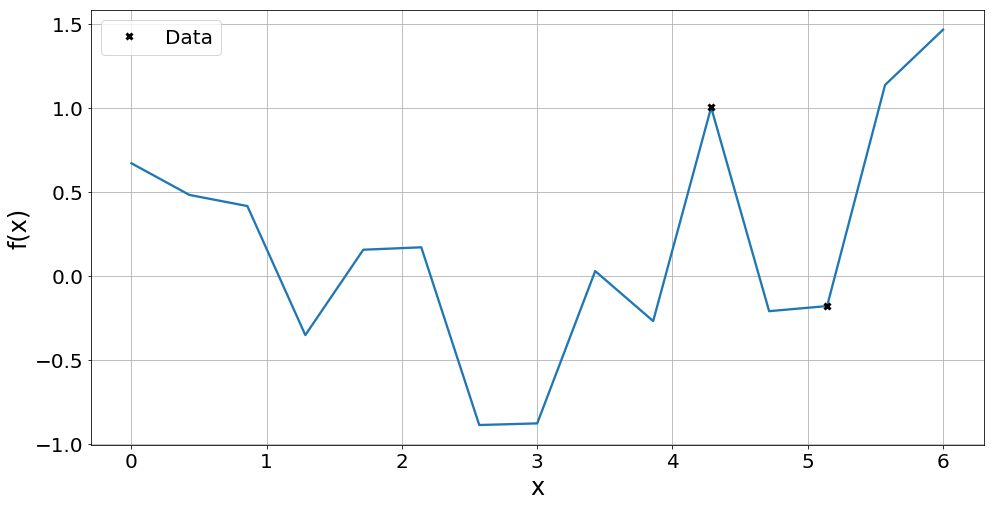

In [4]:
# Plot ground truth and training set
fig = utils.plot2D(None, None, X, [X, Y_true, ''], [X_sample, Y_sample, 'Data', 'kx'])

In [5]:
# Change noise parameter
sigma_n = 0.0
# Construct models with initial guess
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
m = gpflow.models.GPR(X_sample, Y_sample, kern=k)
m.likelihood.variance = sigma_n
m.compile()
# Print out model
m

In [6]:
gpflow.train.ScipyOptimizer().minimize(m)
m

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.179877
  Number of iterations: 15
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.179877
  Number of iterations: 15
  Number of functions evaluations: 17


In [7]:
# Predict with model
mean, var = m.predict_y(X)

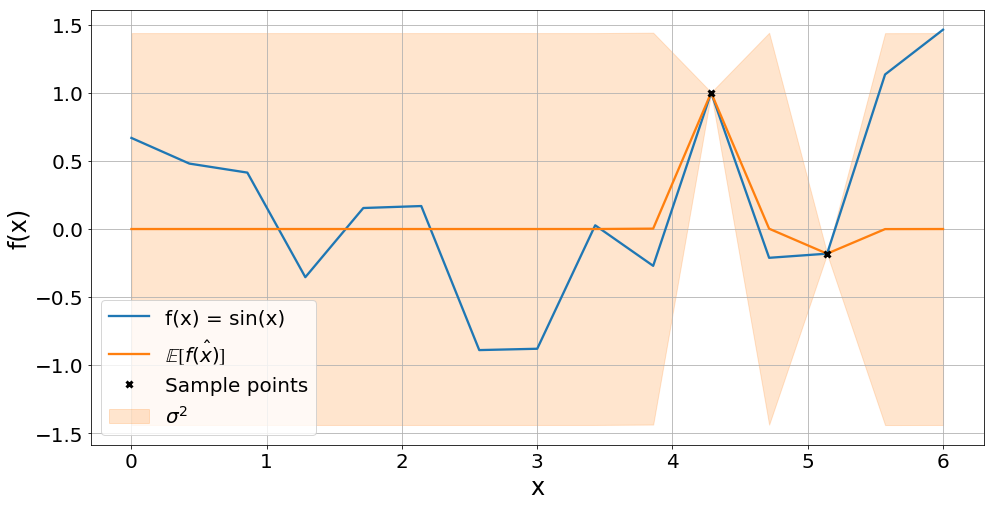

In [8]:
# Plot posterior
fig = utils.plot2D(mean, var, X, [X, Y_true, 'f(x) = sin(x)'], [X, mean, '$\mathbb{E[}\hat{f(x)}\mathbb{]}$'], [X_sample, Y_sample, 'Sample points', 'kx'])

Iteration=1/7


Most informative input at x=[2.14285714]
-----------------------------------------
Iteration=2/7


Most informative input at x=[0.85714286]
-----------------------------------------
Iteration=3/7


Most informative input at x=[3.]
-----------------------------------------
Iteration=4/7
Most informative input at x=[5.57142857]
-----------------------------------------
Iteration=5/7


Most informative input at x=[0.]
-----------------------------------------
Iteration=6/7


Most informative input at x=[3.85714286]
-----------------------------------------
Iteration=7/7
Most informative input at x=[1.71428571]
-----------------------------------------


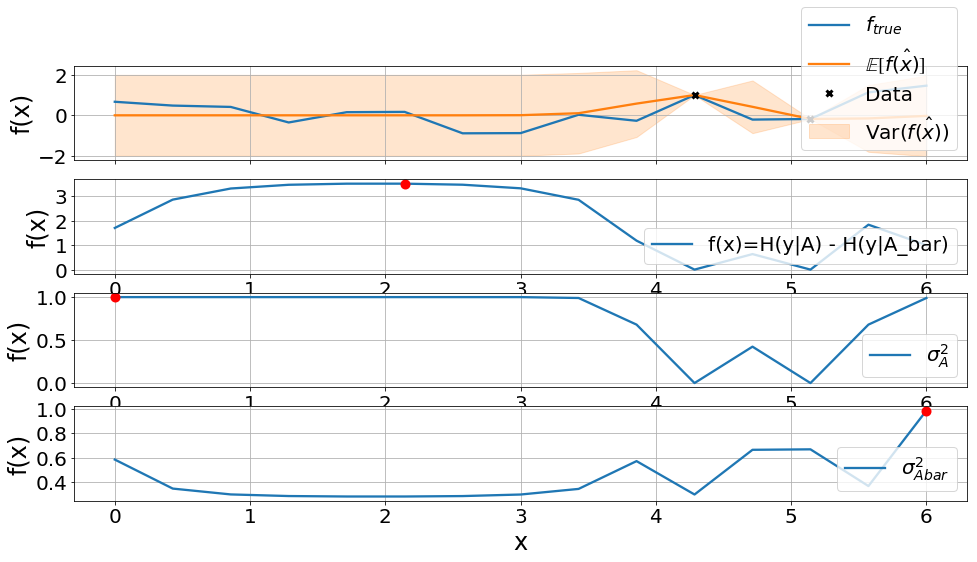

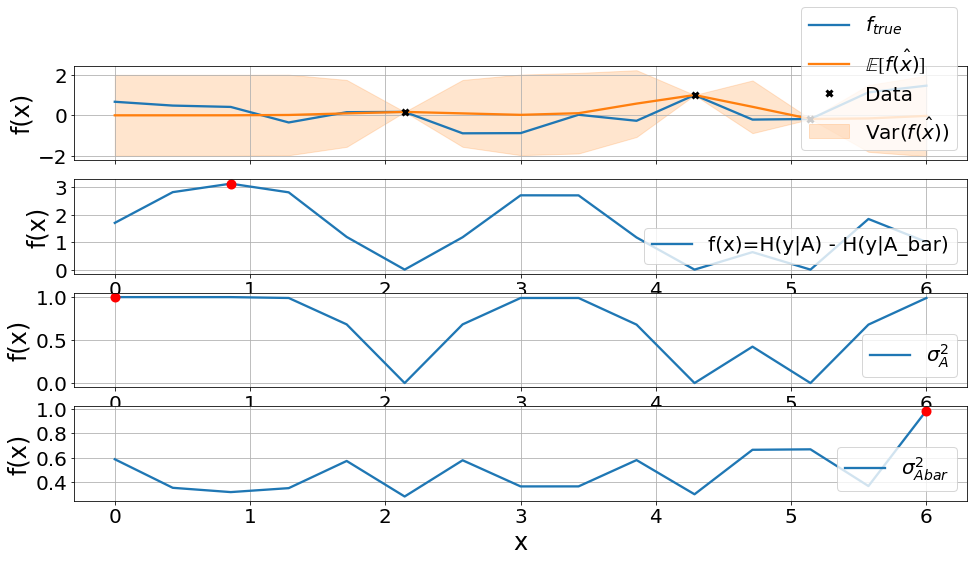

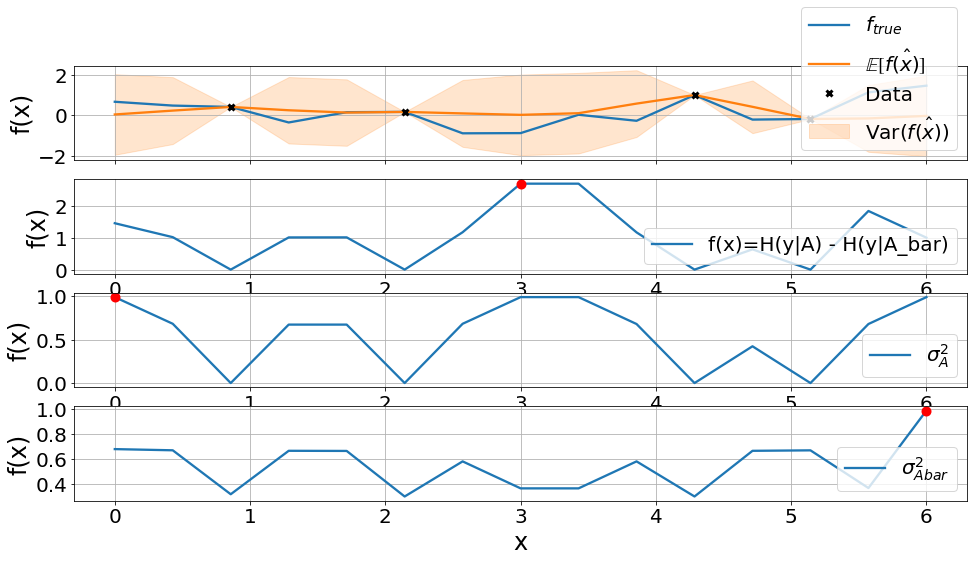

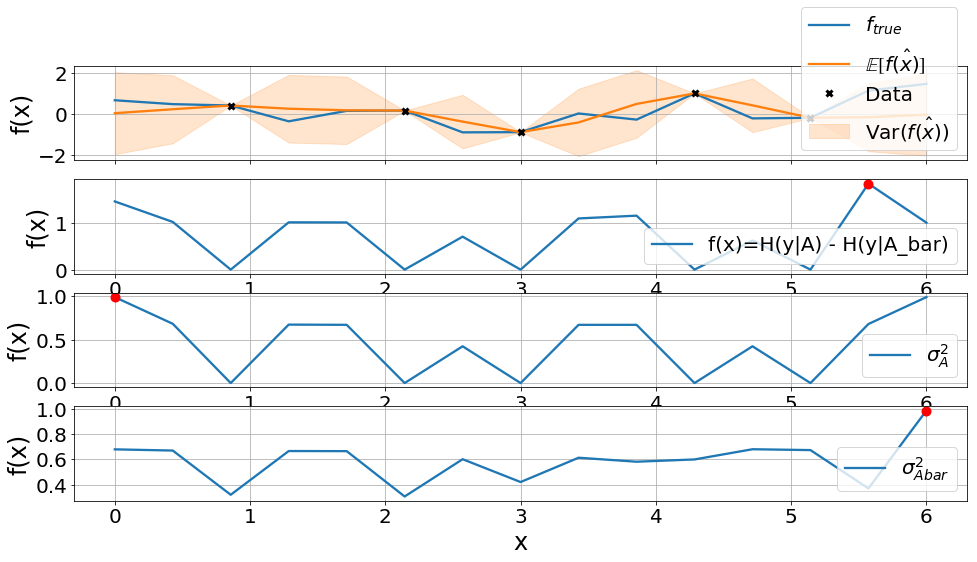

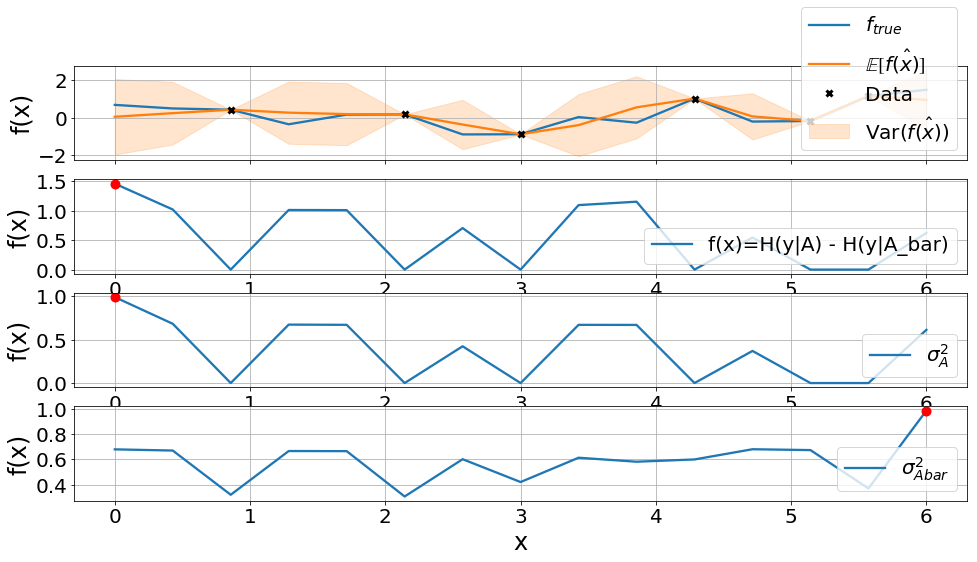

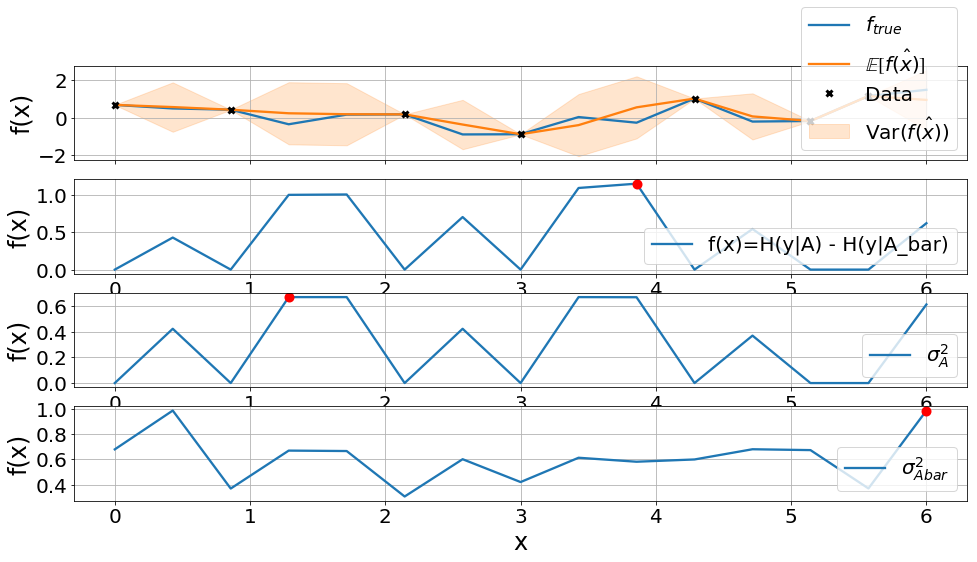

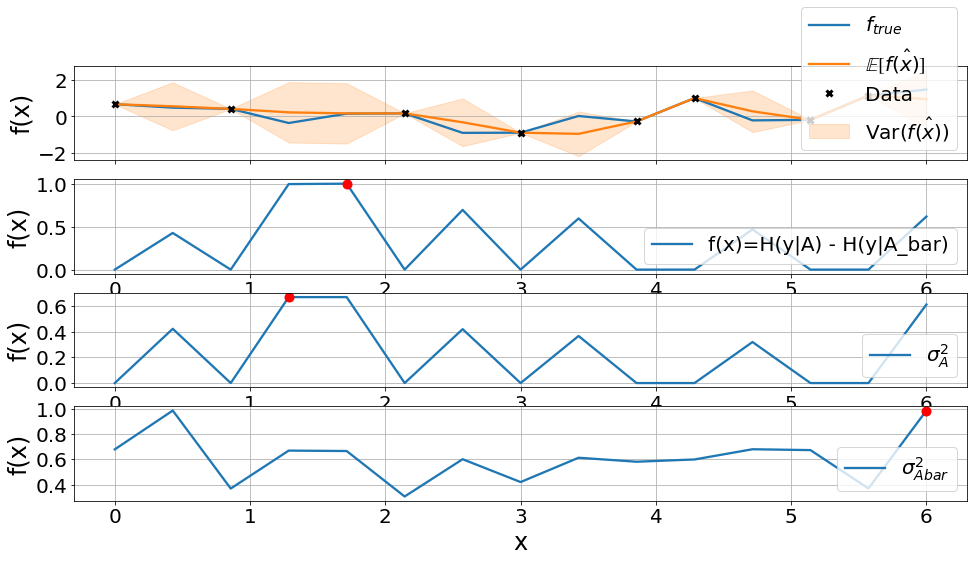

In [9]:
# Set some parameters
lengthscale=0.4
k = gpflow.kernels.RBF(1, lengthscales=lengthscale)
N_samples = 7
sigma_n = 0.0
partwise=True
# Assume some initial samples
size = 2
np.random.seed(57)
index = np.random.choice(range(len(X)), size=size, replace=False)
X_sample = X[index]
Y_sample = Y_true[index]

for i in range(N_samples):
    print('Iteration=' + str(i+1) + "/" + str(N_samples))
    
    # Model for H(y|A)
    m = gpflow.models.GPR(X_sample, Y_sample, kern=k)
    m.likelihood.variance = sigma_n
    m.compile()    
    # Predict with model
    mean_A, var_A = m.predict_y(X)
    
    # Calculate MI
    mi, var_Abar, _, _ = acq.get_MI(X=X, Y_true=Y_true, locs=X_sample, k=k, var_A=var_A, divide=True)
    
    # Plot
    utils.plot_Acq(mean_A, var_A, X, Y_true, X_sample, Y_sample, True, 
                 [X, np.asarray(mi), 'f(x)=H(y|A) - H(y|A_bar)'], [X, var_A, '$\sigma^2_{A}$'],
                   [X, var_Abar, '$\sigma^2_{Abar}$'])
#     utils.plot_Acq(mean_A, var_A, X, Y_true, X_sample, Y_sample, True, [X, np.asarray(mi), 'f(x)=H(y|A) - H(y|A_bar)'])
    
    # Append new point
    print("Most informative input at x=" + str(X[np.argmax(np.asarray(mi))]))
    print("-----------------------------------------")  
    X_sample = np.append(X_sample, [X[np.argmax(np.asarray(mi))]], axis=0)
    Y_sample = np.append(Y_sample, [Y_true[np.argmax(np.asarray(mi))]], axis=0)

Iteration=1/7


Most informative input at x=[2.14285714]
-----------------------------------------
Iteration=2/7


Most informative input at x=[0.85714286]
-----------------------------------------
Iteration=3/7


Most informative input at x=[3.]
-----------------------------------------
Iteration=4/7


Most informative input at x=[5.57142857]
-----------------------------------------
Iteration=5/7


Most informative input at x=[0.]
-----------------------------------------
Iteration=6/7


Most informative input at x=[3.85714286]
-----------------------------------------
Iteration=7/7
Most informative input at x=[1.71428571]
-----------------------------------------


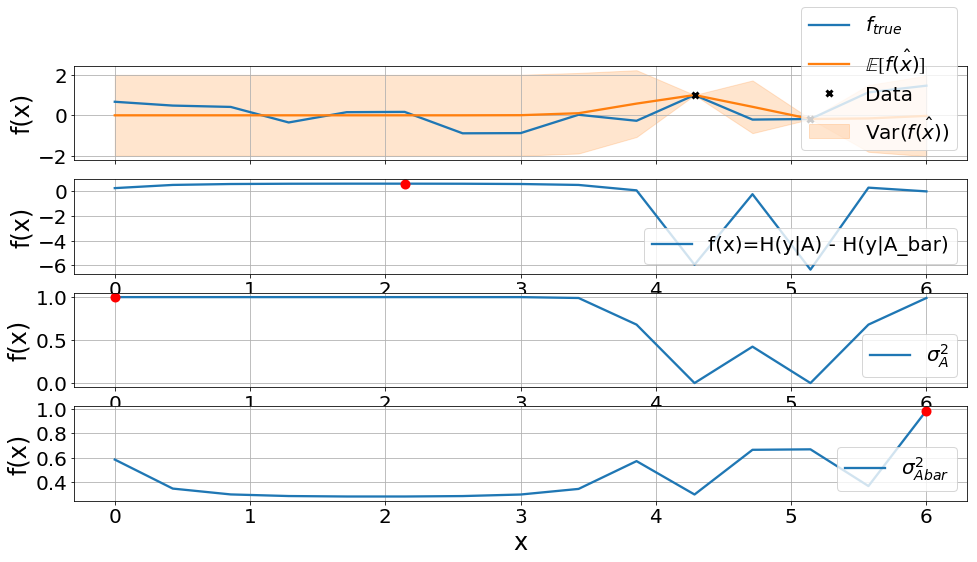

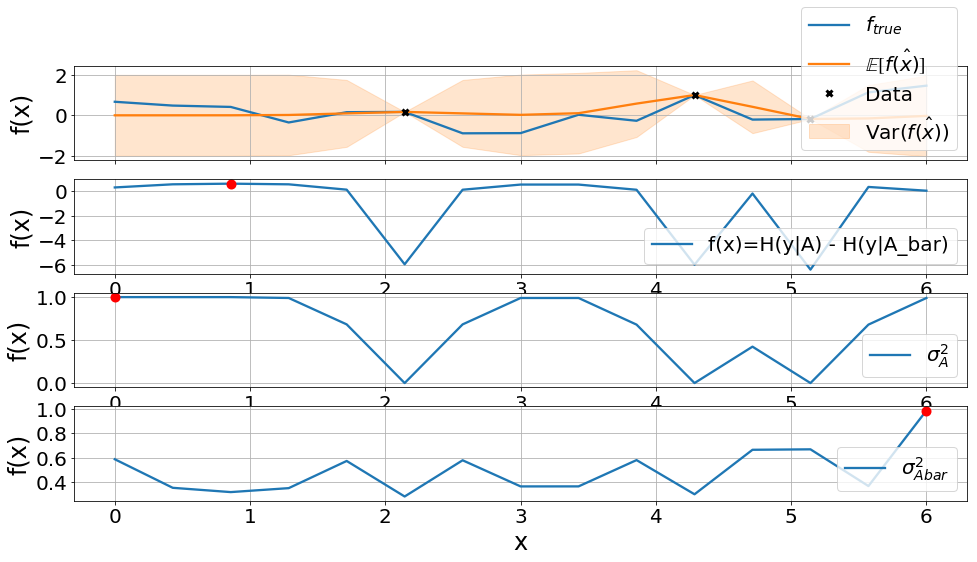

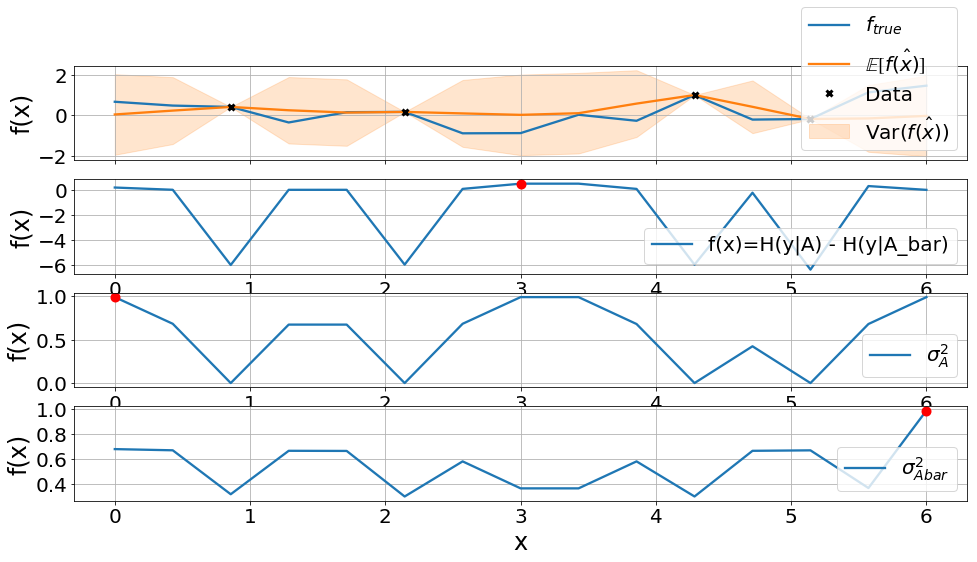

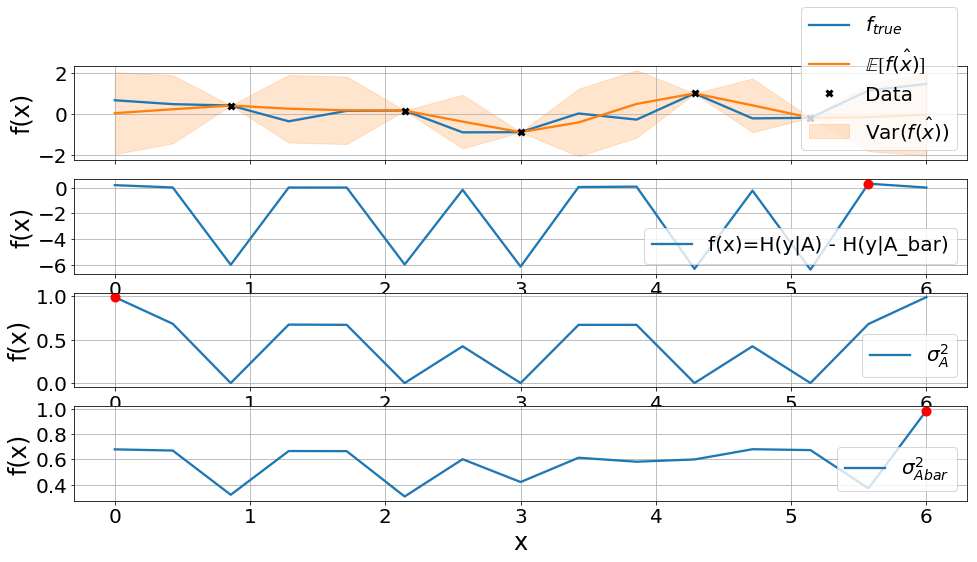

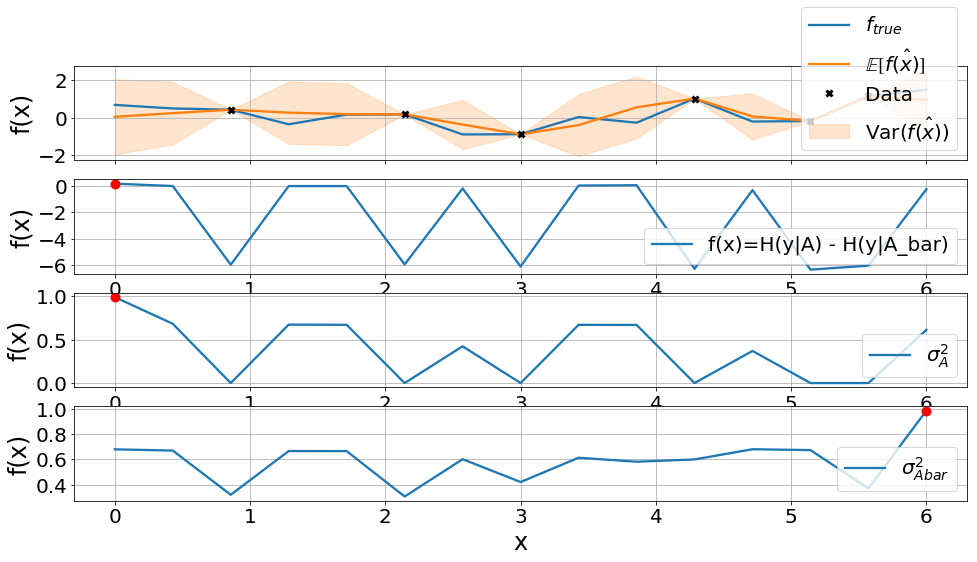

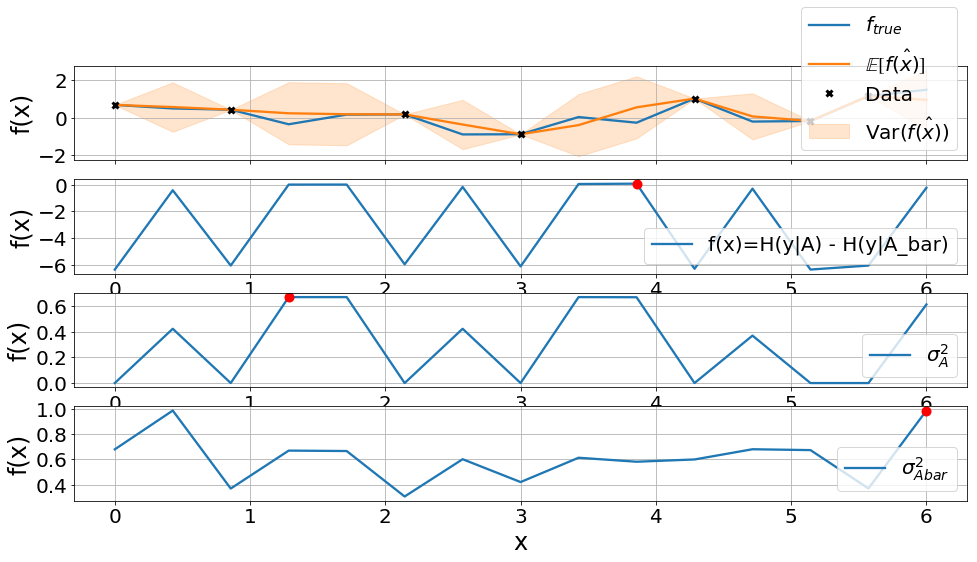

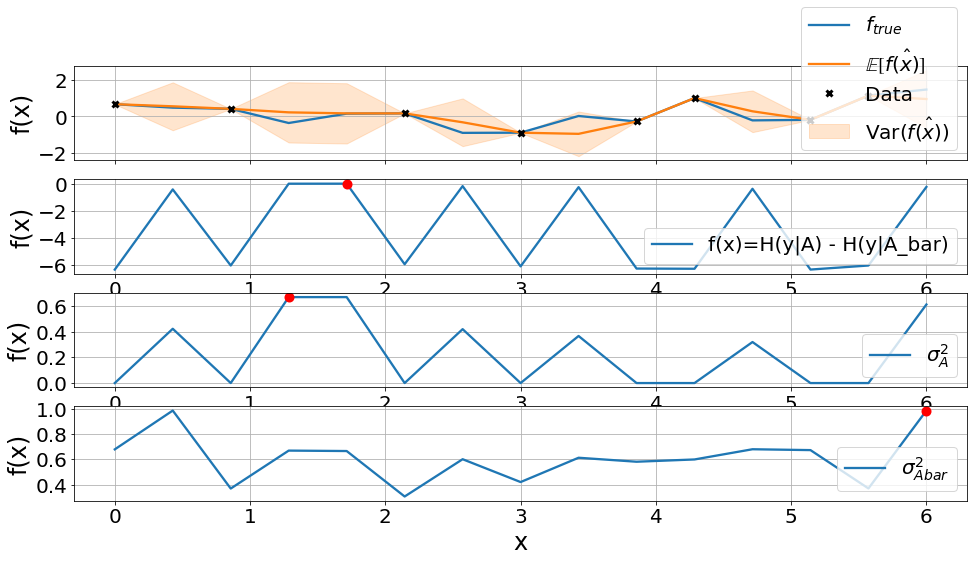

In [10]:
# Set some parameters
lengthscale=0.4
k = gpflow.kernels.RBF(1, lengthscales=lengthscale)
N_samples = 7
sigma_n = 0.0
partwise=True
# Assume some initial samples
size = 2
np.random.seed(57)
index = np.random.choice(range(len(X)), size=size, replace=False)
X_sample = X[index]
Y_sample = Y_true[index]
for i in range(N_samples):
    print('Iteration=' + str(i+1) + "/" + str(N_samples))
    
    # Model for H(y|A)
    m = gpflow.models.GPR(X_sample, Y_sample, kern=k)
    m.likelihood.variance = sigma_n
    m.compile()    
    # Predict with model
    mean_A, var_A = m.predict_y(X)

    # Calculate MI
    mi, var_Abar, _, _ = acq.get_MI(X=X, Y_true=Y_true, locs=X_sample, k=k, var_A=var_A, divide=False)
    
    # Plot
    utils.plot_Acq(mean_A, var_A, X, Y_true, X_sample, Y_sample, True, 
                 [X, np.asarray(mi), 'f(x)=H(y|A) - H(y|A_bar)'], [X, var_A, '$\sigma^2_{A}$'],
                   [X, var_Abar, '$\sigma^2_{Abar}$'])
#     utils.plot_Acq(mean_A, var_A, X, Y_true, X_sample, Y_sample, True, 
#                  [X, np.asarray(mi), 'f(x)=H(y|A) - H(y|A_bar)', False])
    
    # Append new point
    print("Most informative input at x=" + str(X[np.argmax(np.asarray(mi))]))
    print("-----------------------------------------")  
    X_sample = np.append(X_sample, [X[np.argmax(np.asarray(mi))]], axis=0)
    Y_sample = np.append(Y_sample, [Y_true[np.argmax(np.asarray(mi))]], axis=0)

## 2D

(-3.0, 3.0)

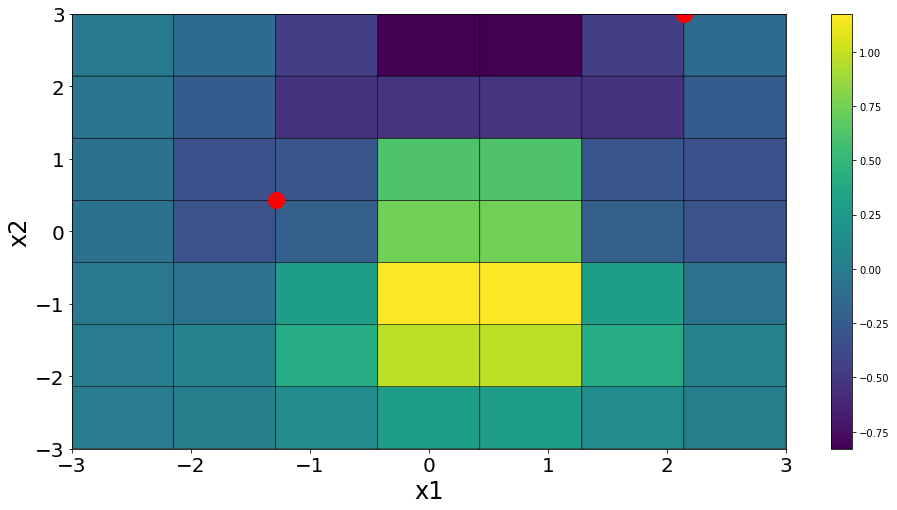

In [11]:
def f(x,y):
    return (1-(x**2+y**3)) * np.exp(-(x**2+y**2)/2)


markersize = 12
num = 8
# Generate data
bound = 3.
x1 = np.linspace(-bound, bound, num)
x2 = np.linspace(-bound, bound, num)
x1_mesh,x2_mesh = np.meshgrid(x1, x2)
X = np.dstack([x1_mesh, x2_mesh]).reshape(-1, 2)
z = f(x1_mesh, x2_mesh) # evaluation of the function on the grid
# Draw samples from feature vectors and function by a given index
size = 2
np.random.seed(1608)
index = np.random.choice(range(len(x1)), size=(size,X.ndim), replace=False)
samples = utils.sampleFeature([x1,x2], index)
X1_sample = samples[0]
X2_sample = samples[1]  
X_sample = np.column_stack((X1_sample, X2_sample))
Y_sample = utils.samplefromFunc(f=z, ind=index)

# Plot ground truth and samples
cbar = plt.pcolor(x1, x2, z, edgecolors='k', linewidths=0.5)
plt.colorbar(cbar)
for r in range(len(index)):
    plt.plot(x1[index[r][0]], x2[index[r][1]],marker='.', color='r', linestyle='none', markersize=markersize+20)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.xlabel('x1', fontsize=fontsize_label)
plt.ylabel('x2', fontsize=fontsize_label)
ax = plt.gca()
ax.set_xlim(-bound, bound)
ax.set_ylim(-bound, bound)


# fig = plt.figure(figsize=(18, 12))
# ax = plt.gca()
# # Using matshow here just because it sets the ticks up nicely. imshow is faster.
# ax.matshow(z.T, cmap=cm.viridis)

# for (i, j), val in np.ndenumerate(z):
#     ax.text(j, i, '{:0.5f}'.format(val), ha='center', va='center')

# plt.show()

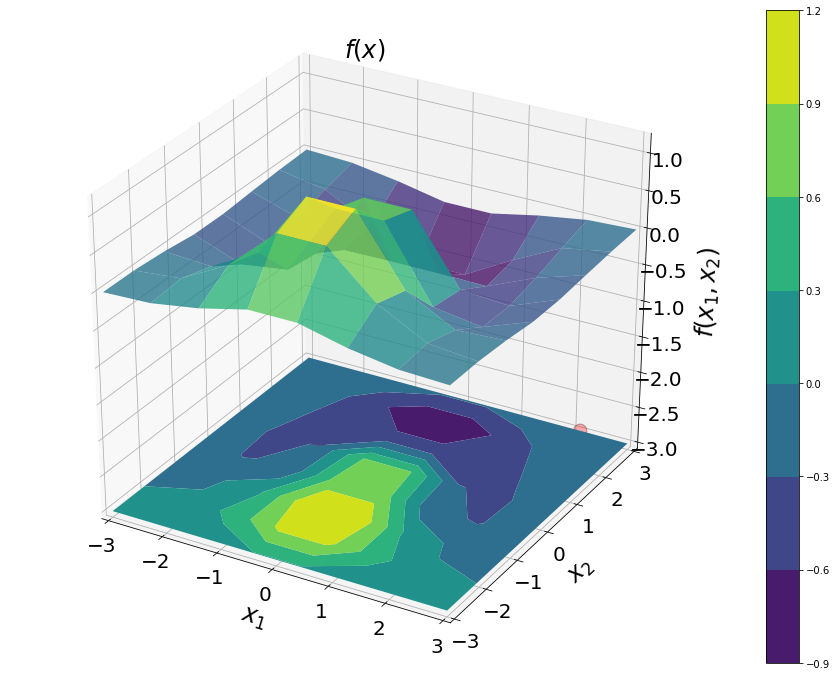

In [12]:
offset = -3.
utils.plot3D(x1_mesh, x2_mesh, z, X_sample[:,0], X_sample[:,1], offset, bound, markersize=180)

In [13]:
# Change noise parameter
sigma_n = 0.0
# Construct models with initial guess
k = gpflow.kernels.RBF(2,active_dims=[0,1], lengthscales=1.0)
m = gpflow.models.GPR(X_sample, Y_sample, kern=k)
m.likelihood.variance = sigma_n
m.compile()
# Print out model
m

In [14]:
gpflow.train.ScipyOptimizer().minimize(m)
m

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.466253
  Number of iterations: 12
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 2.466253
  Number of iterations: 12
  Number of functions evaluations: 15


In [15]:
mean, var = m.predict_y(X)
print(mean.shape)
mean_square = mean.reshape(x1_mesh.shape) # Shape: (num,num)
var_square = var.reshape(x1_mesh.shape) # Shape: (num,num)

(64, 1)


In [16]:
print(X.shape)
print(z.reshape(-1,1).shape)
print(X.reshape(-1,1).shape)

(64, 2)
(64, 1)
(128, 1)


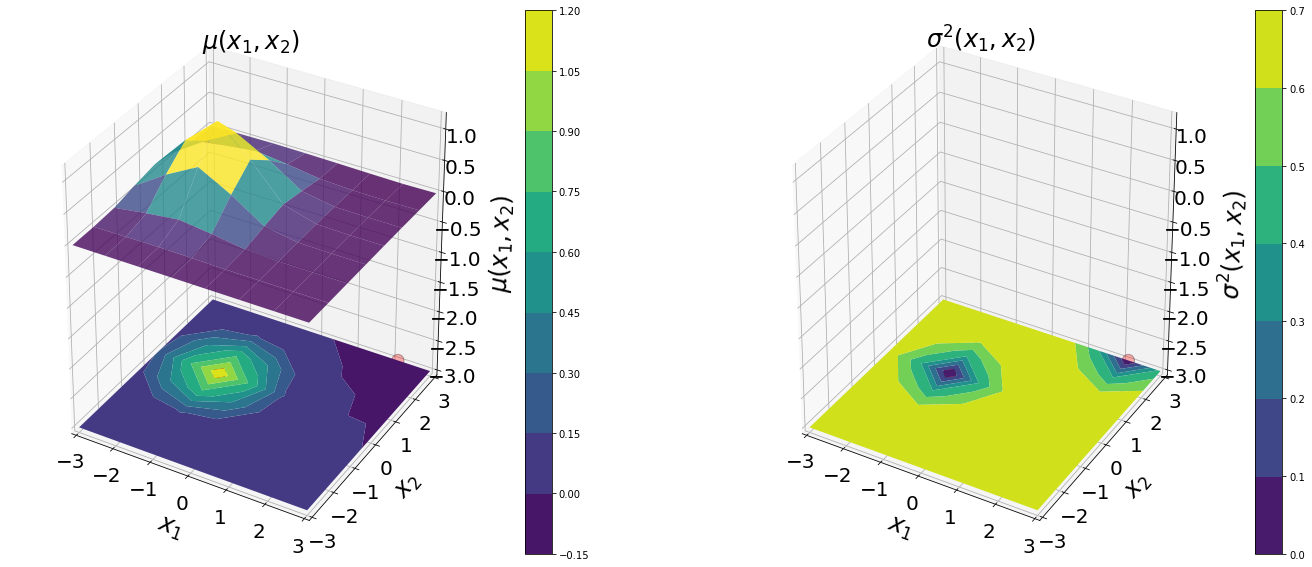

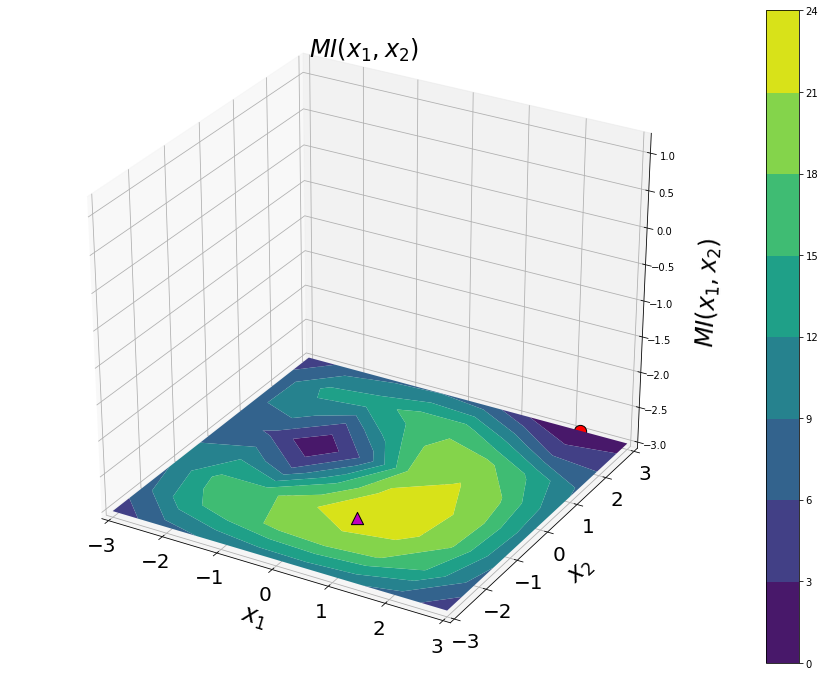

In [19]:
mi, _, _, _ = acq.get_MI(X=X, Y_true=z, locs=X_sample, k=k, var_A=var, divide=True)
mi_square = mi.reshape(x1_mesh.shape)
utils.plotAcq3D(mean_square, var_square, x1_mesh, x2_mesh, X_sample, bound, True, [mi_square, '$MI(x_1,x_2)$'])

Iteration=1/7
Time needed for calculating MI=2.3606443405151367


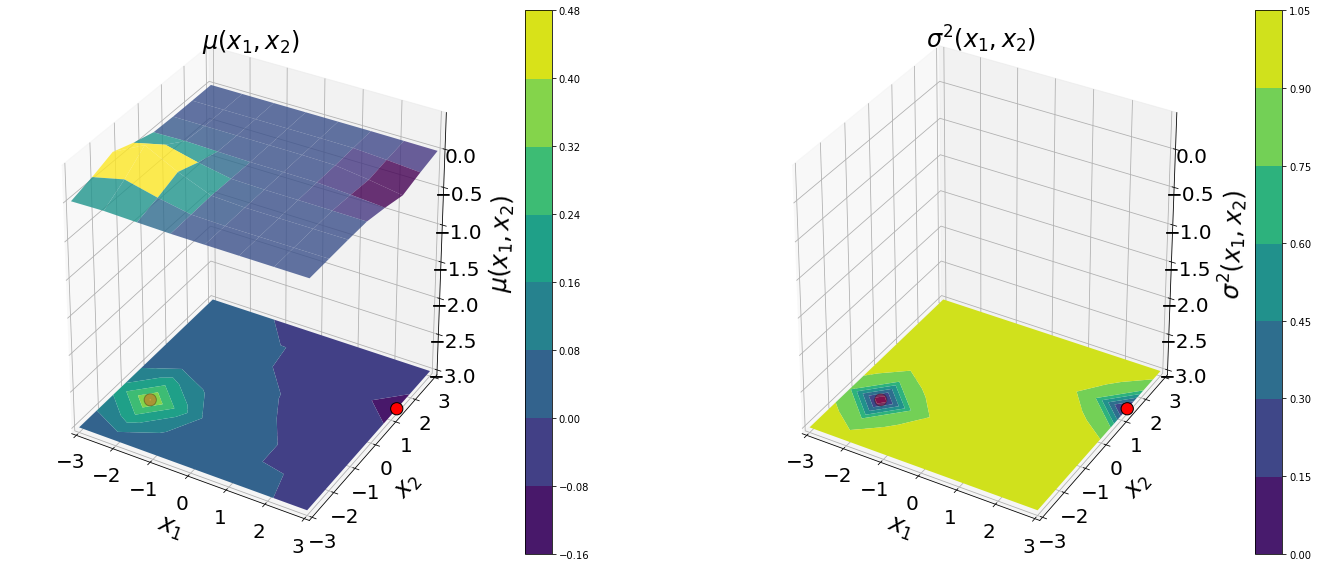

Time needed for plotting=1.1252188682556152
Overall time needed=3.486138343811035
Most informative input at x=[0.42857143 0.42857143]
----------------------------------------------------
Iteration=2/7
Time needed for calculating MI=2.0512475967407227


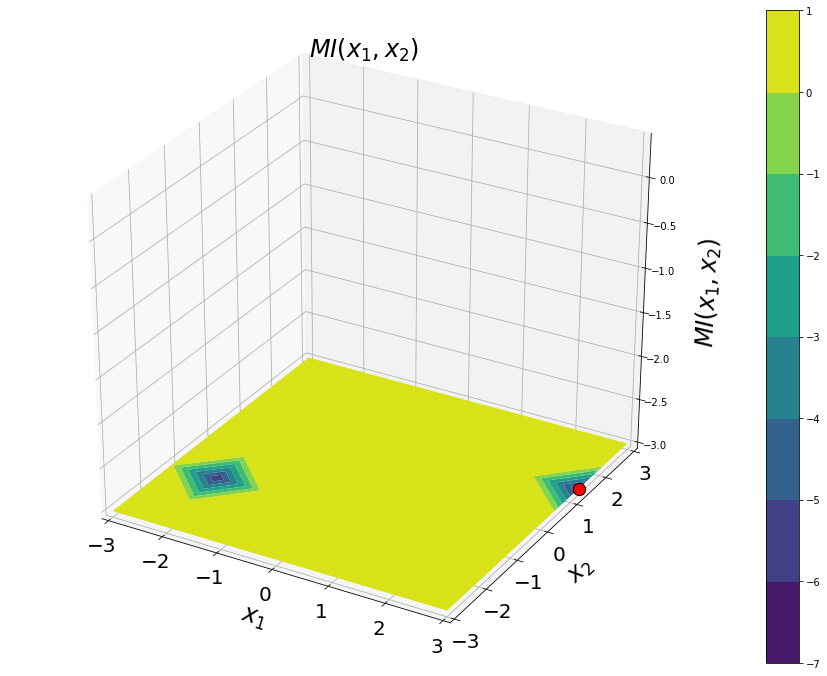

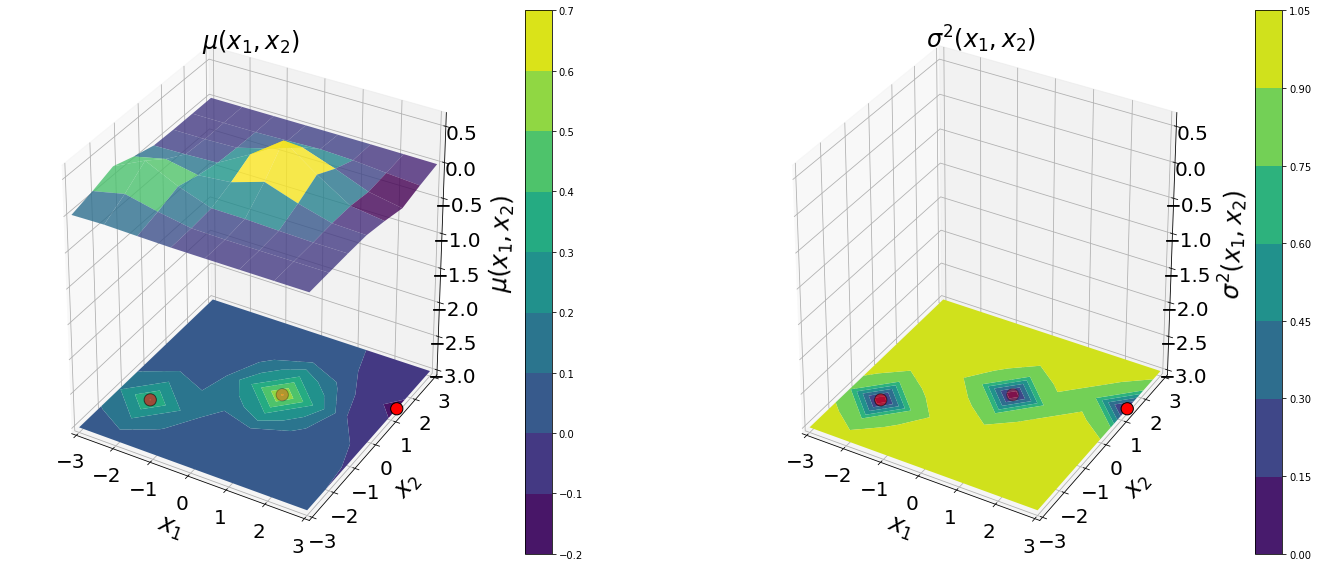

Time needed for plotting=1.9289731979370117
Overall time needed=3.980675220489502
Most informative input at x=[-1.28571429  1.28571429]
----------------------------------------------------
Iteration=3/7
Time needed for calculating MI=2.049668550491333


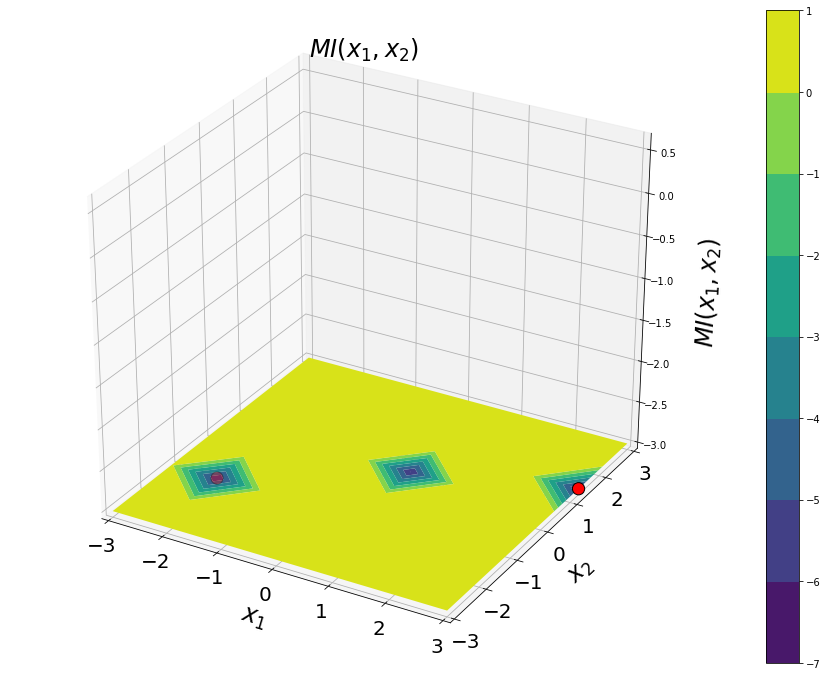

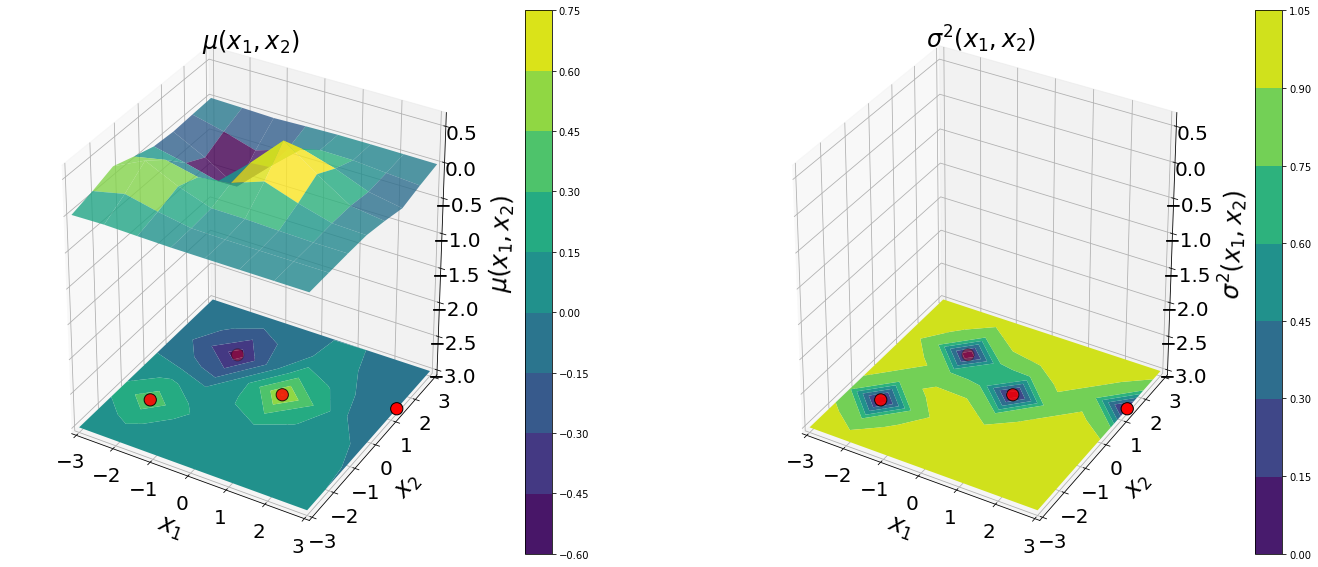

Time needed for plotting=1.7019376754760742
Overall time needed=3.751919984817505
Most informative input at x=[ 0.42857143 -1.28571429]
----------------------------------------------------
Iteration=4/7
Time needed for calculating MI=1.9916279315948486


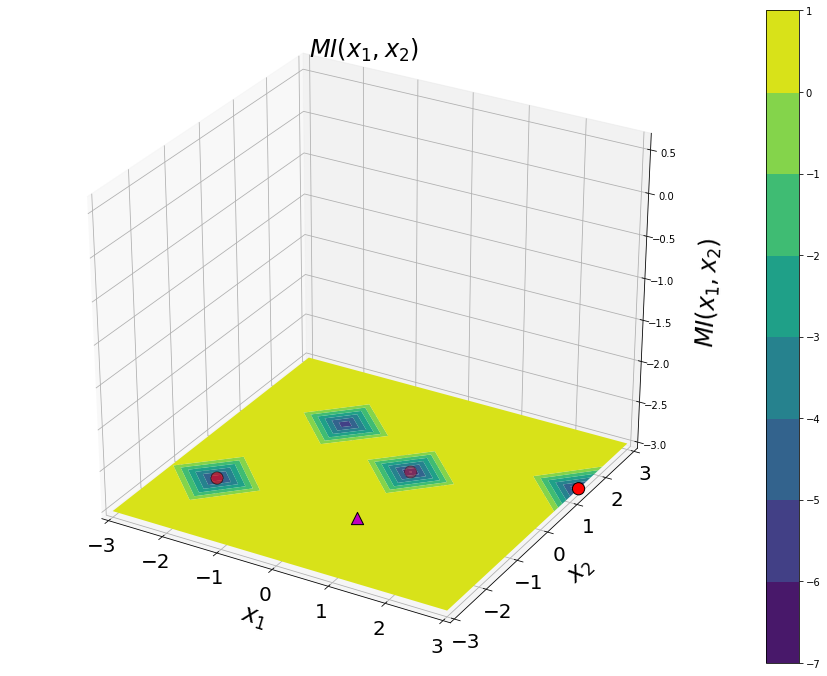

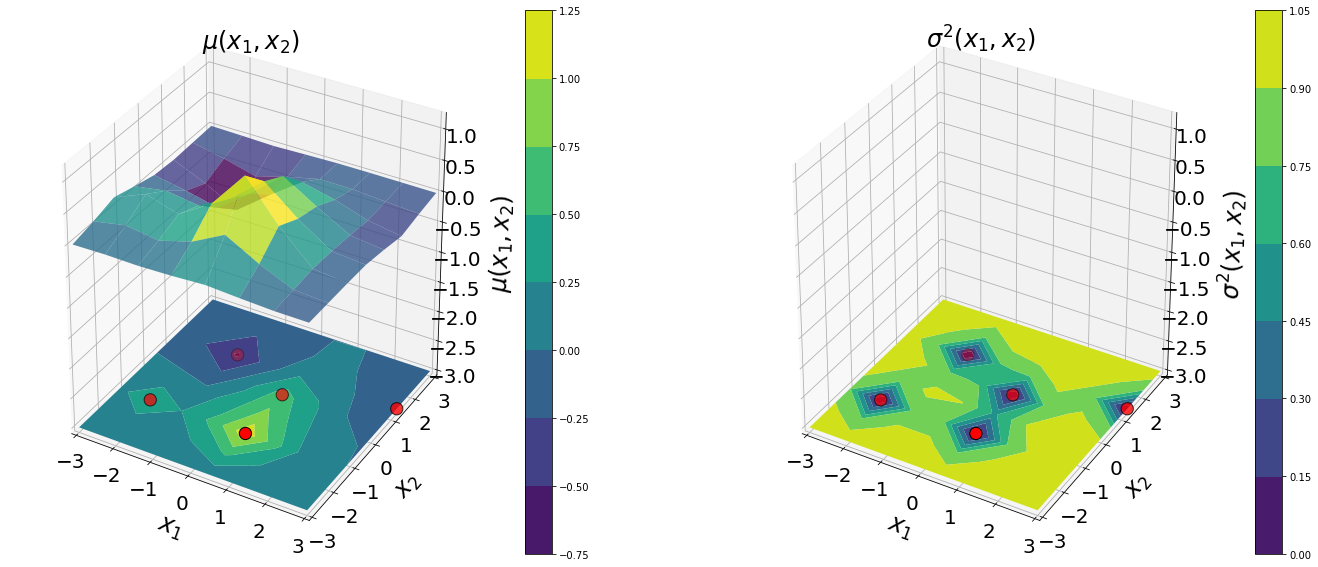

Time needed for plotting=1.8984391689300537
Overall time needed=3.8903801441192627
Most informative input at x=[-0.42857143 -2.14285714]
----------------------------------------------------
Iteration=5/7
Time needed for calculating MI=2.088796377182007


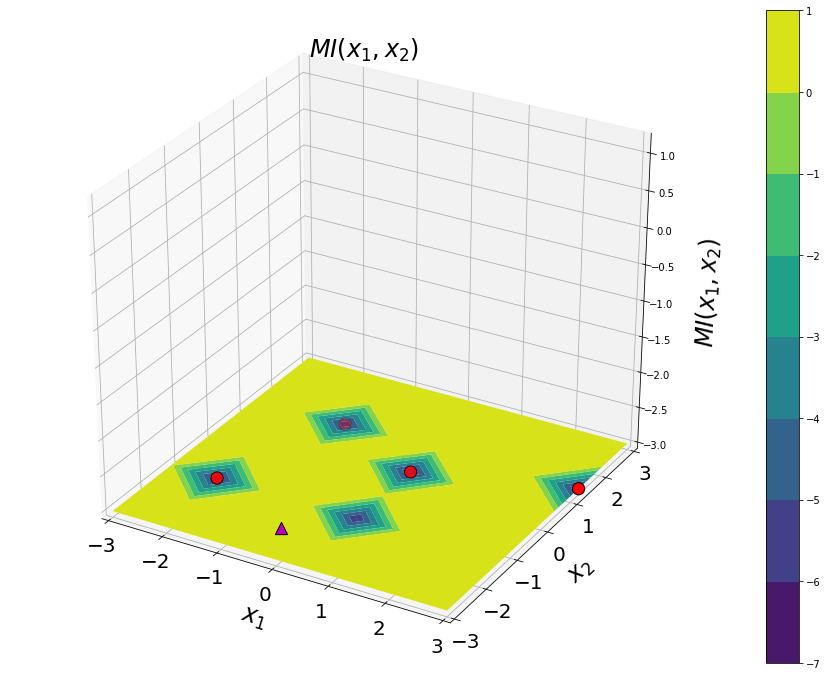

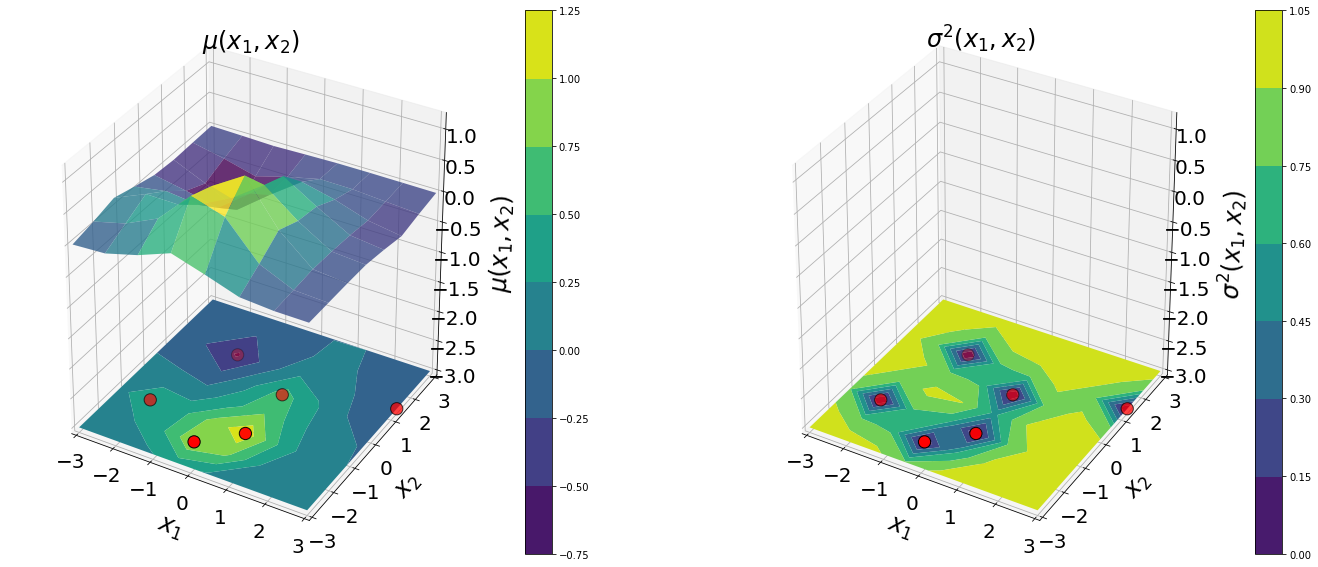

Time needed for plotting=1.7062089443206787
Overall time needed=3.795367479324341
Most informative input at x=[-1.28571429 -0.42857143]
----------------------------------------------------
Iteration=6/7
Time needed for calculating MI=2.044360876083374


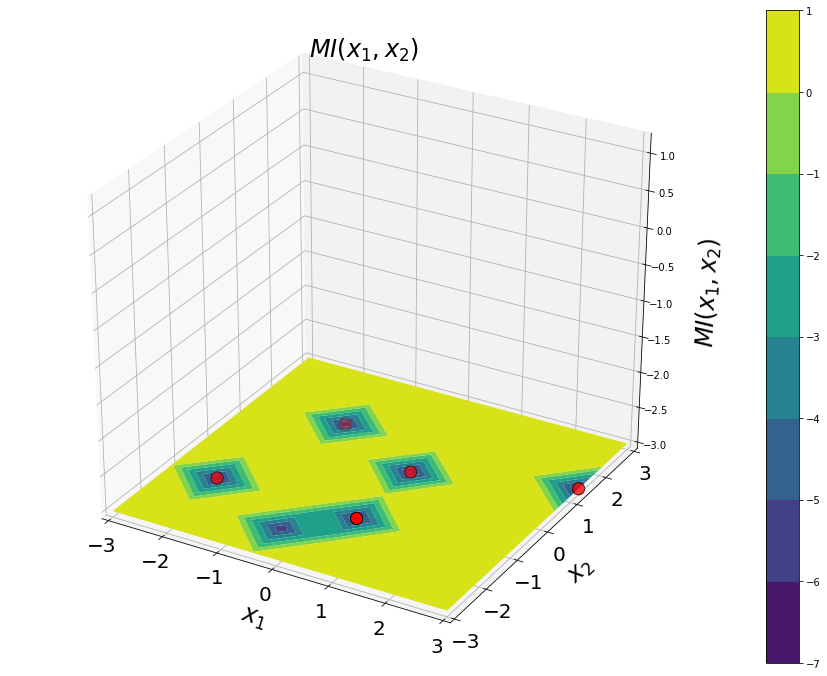

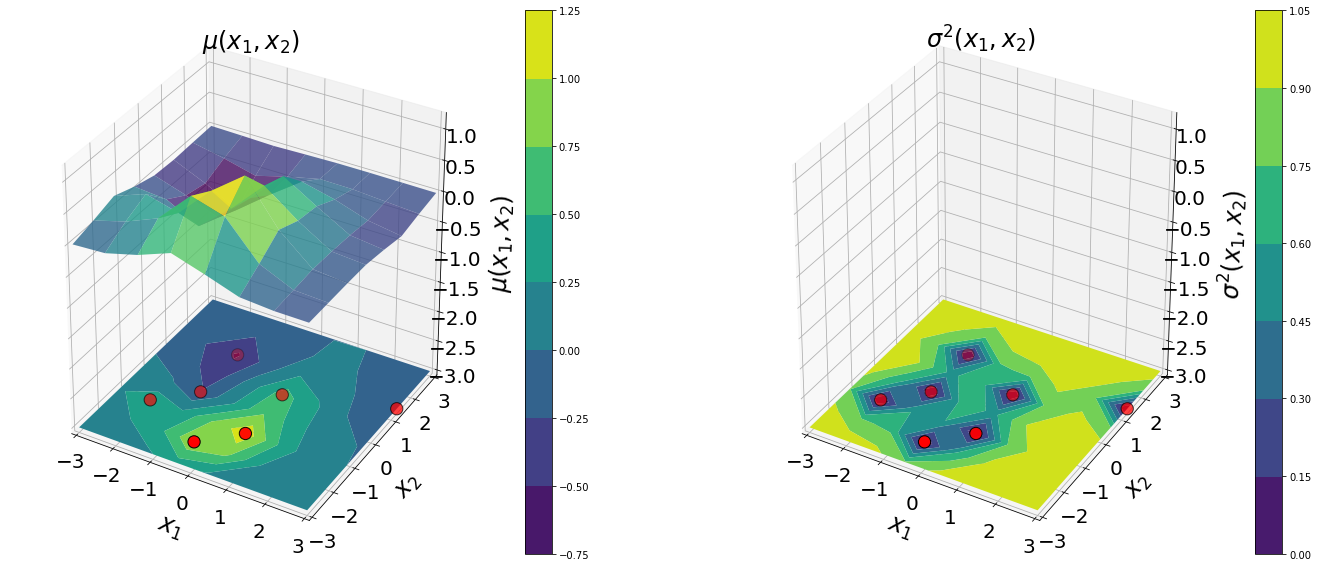

Time needed for plotting=1.731818437576294
Overall time needed=3.776503324508667
Most informative input at x=[-2.14285714  2.14285714]
----------------------------------------------------
Iteration=7/7
Time needed for calculating MI=2.089967966079712


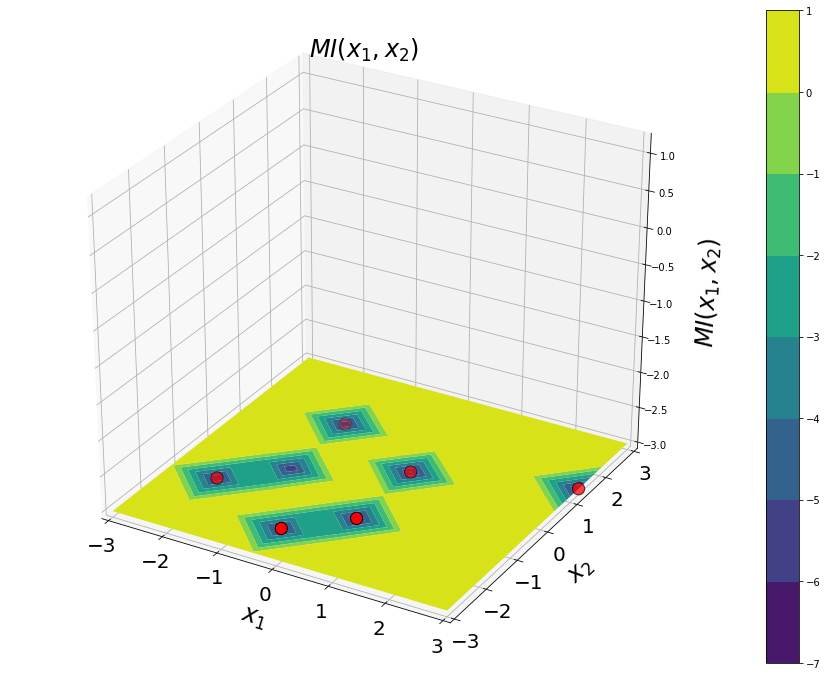

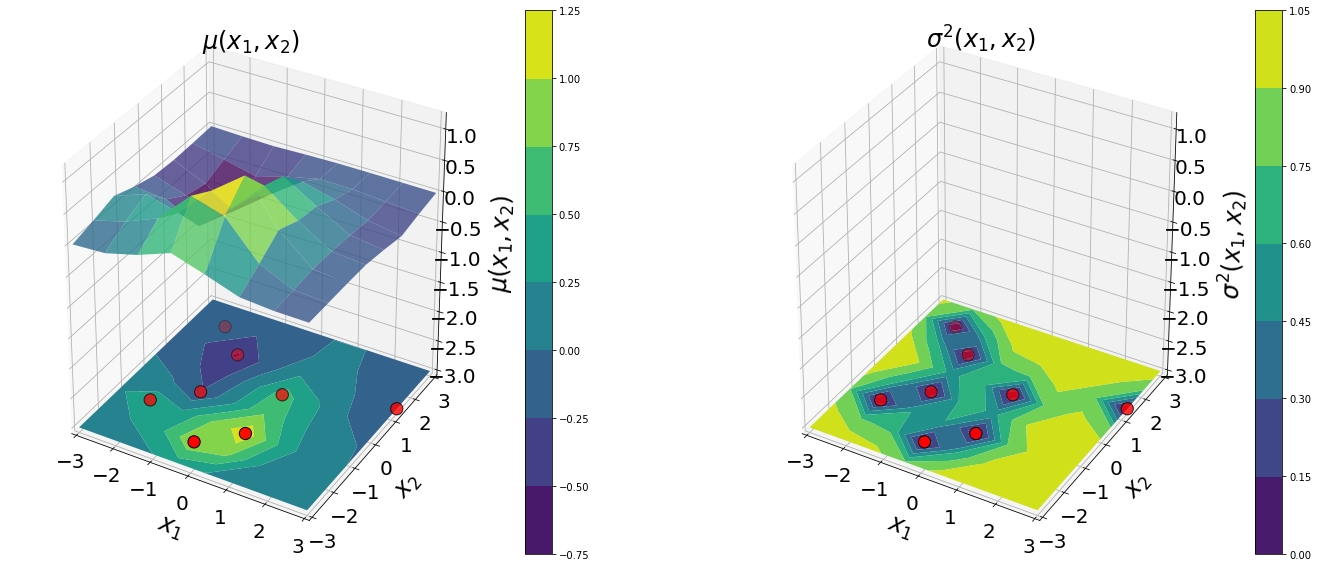

Time needed for plotting=1.6974115371704102
Overall time needed=3.787662982940674
Most informative input at x=[-0.42857143  2.14285714]
----------------------------------------------------


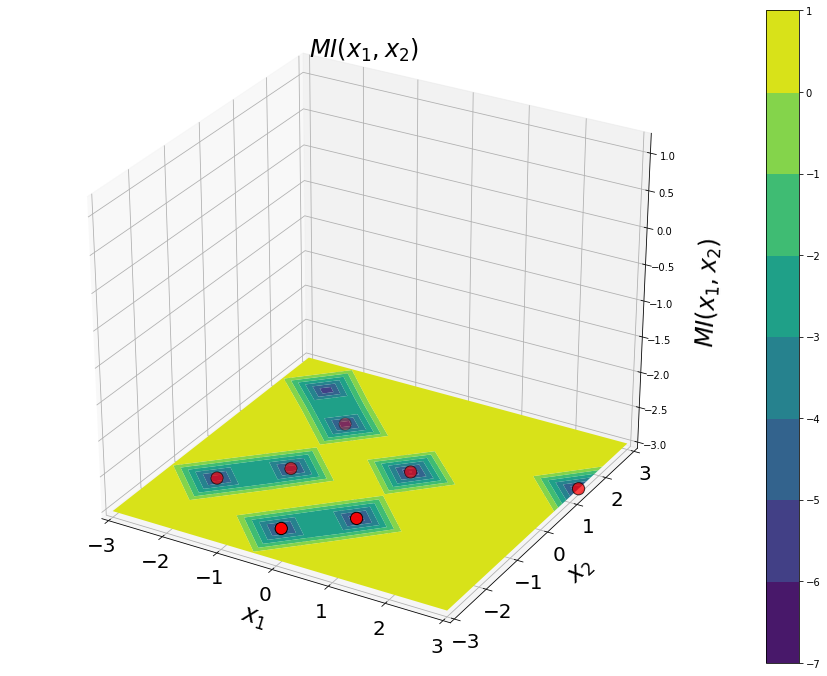

In [20]:
# Set some parameters
lengthscale = 0.7
k = gpflow.kernels.RBF(input_dim=2, lengthscales=lengthscale)
N_samples = 7
sigma_n = 0.0

# Draw samples from feature vectors and function by a given index
size = 2
np.random.seed(1991)
index = np.random.choice(range(len(x1)), size=(size,X.ndim), replace=False)
samples = utils.sampleFeature([x1,x2], index)
X1_sample = samples[0]
X2_sample = samples[1]  
X_sample = np.column_stack((X1_sample, X2_sample))
Y_sample = utils.samplefromFunc(f=z, ind=index)

# Compute MI
durations = []
for i in range(N_samples):
    print('Iteration=' + str(i+1) + "/" + str(N_samples))
    start_time = time.time()
        # Estimate model on samples
    m = gpflow.models.GPR(X_sample, Y_sample, kern=k)
    m.likelihood.variance = sigma_n
#     m.kern.lengthscales.trainable = False
#     m.likelihood.variance.trainable = False
    m.compile()
#     gpflow.train.ScipyOptimizer().minimize(m)
    
    # Predict with model
    mean, var = m.predict_y(X)
    mean_square = mean.reshape(x1_mesh.shape) # Shape: (num,num)
    var_square = var.reshape(x1_mesh.shape) # Shape: (num,num)
    
    # Calculate MI
    mi, var_Abar, h_yA, h_yAbar = acq.get_MI(X=X, Y_true=z, locs=X_sample, k=k, var_A=var, divide=False)

    mi_square = mi.reshape(x1_mesh.shape)
    elapsed_time = time.time() - start_time
    print("Time needed for calculating MI="+str(elapsed_time))
    # Plot
    start_time2 = time.time()
    utils.plotAcq3D(mean_square, var_square, x1_mesh, x2_mesh, X_sample, bound, True, [mi_square, '$MI(x_1,x_2)$'])

    elapsed_time = time.time() - start_time2
    print("Time needed for plotting="+str(elapsed_time))
    # Append new point
    X_sample = np.vstack((X_sample, np.asarray([x1_mesh.reshape(-1)[np.argmax(mi)], x2_mesh.reshape(-1)[np.argmax(mi)]])))
    Y_sample = np.vstack((Y_sample,np.asarray([z.reshape(-1)[np.argmax(mi)]])))
    elapsed_time = time.time() - start_time
    print("Overall time needed="+str(elapsed_time))
    print("Most informative input at x=" + str(X[np.argmax(np.asarray(mi))]))
    print("----------------------------------------------------")
    durations.append(elapsed_time)

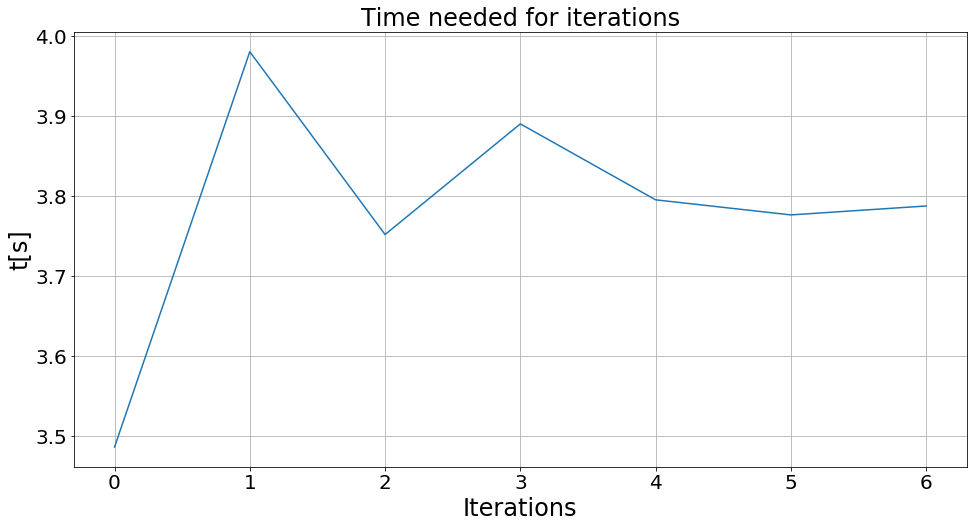

In [21]:
plt.plot(durations)
plt.title("Time needed for iterations", fontsize=fontsize_title)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.xlabel('Iterations', fontsize=fontsize_label)
plt.ylabel('t[s]', fontsize=fontsize_label)
plt.grid()